# **Advanced Classification EDSA**- Climate Change Belief Analysis 2021

## *Introduction*

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.
Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

<img src="image's/bigstock-climate-change-warning-sign.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

## **Overview**

#### *The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:*
- Class  1 = "the tweet supports the belief of man-made"
- Class  2 = "the tweet links to factual news about climate change"
- Class  0 = "the tweet neither supports nor refutes the belief of man-made climate change"
- Class -1 = "the tweet does not believe in man-made climate change"
- Sentiment: Sentiment of tweet message


## **Import Dependencies**

In [1]:
# Load EDA Pkgs
import pandas as pd
import numpy as np

# Load Data for Viz 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import skmultilearn 

os.getcwd()
# Ml  packages
from nltk.tokenize import TreebankWordTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
# Split Dataset into training and text
from sklearn.model_selection import train_test_split
#feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
# text preprocessing
import string
import nltk

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [2]:
df = pd.read_csv('train.csv')

In [3]:
# getting to know your data
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
column_titles = [col for col in df.columns if col!= 'sentiment'] + ['sentiment']
df = df.reindex(columns=column_titles)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   tweetid    15819 non-null  int64 
 2   sentiment  15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


Text(0.5, 0, 'classes')

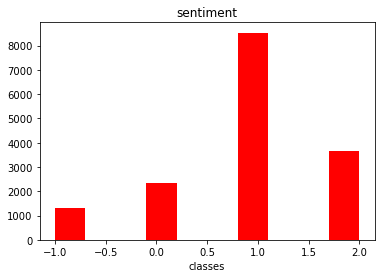

In [7]:
classes = df['sentiment']
plt.hist(classes,color="r")
plt.title("sentiment")
plt.xlabel('classes')

### 2. Preprocess the Data

Preprocessing the data is an essential step in natural language process. In the following cells, we will convert our class labels to binary values using the LabelEncoder from sklearn, replace email addresses, URLs, phone numbers, and other symbols by using regular expressions, remove stop words, and extract word stems.  

In [8]:
text_messages = df['message']
y = classes

In [9]:
import re

processed = text_messages.str.replace("@[\w.]+",'emailaddress')
# Replace URLs with 'webaddress'
processed = processed.str.replace(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*','webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbers'
processed = processed.str.replace(r'\d+(\.\d+)?', 'number')


In [10]:

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')
#replacing pun
processed = processed.str.replace(r'[^\w\s]', '')

In [11]:
processed = processed.str.lower()
print(processed.head())

0    polyscimajor epa chief doesnt think carbon dio...
1    its not like we lack evidence of anthropogenic...
2    rt emailaddress researchers say we have three ...
3    todayinmaker wired  number was a pivotal year ...
4    rt emailaddress its number and a racist sexist...
Name: message, dtype: object


In [12]:
from nltk.corpus import stopwords

stop_words = (stopwords.words('english'))
stop_words.append("rt")
stop_words = set(stop_words)
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

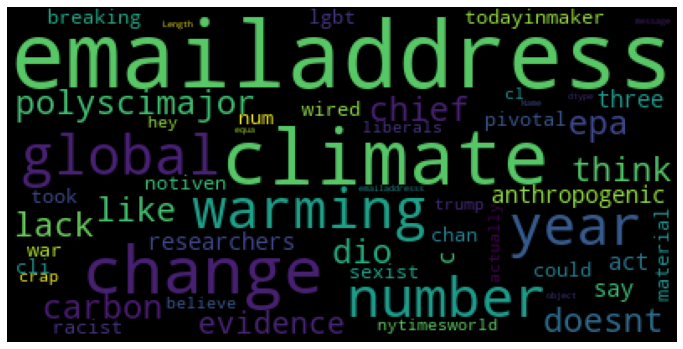

In [13]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=stop_words,max_words=100,max_font_size=1500, random_state=42).generate(str(processed))
fig = plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
# Remove word stems using a Porter stemmer
ps = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))

### 3. Feature engineering

Feature engineering is the process of using domain knowledge of the data to create features for machine learning algorithms. In this project, the words in each text message will be our features.  For this purpose, it will be necessary to tokenize each word.  We will use the 1500 most common words as features.

In [15]:
from nltk.tokenize import word_tokenize

# create bag-of-words
all_words = []

for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

In [16]:
# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 12959
Most common words: [('emailaddress', 14670), ('climat', 12957), ('chang', 12578), ('webaddress', 9576), ('global', 3792), ('warm', 3555), ('trump', 2377), ('number', 1686), ('believ', 1321), ('think', 967), ('us', 900), ('say', 884), ('amp', 877), ('doesnt', 829), ('go', 805)]


In [17]:
# use the 1500 most common words as features
word_features = list(all_words.keys())[:1500]

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(processed)

In [20]:
list(cv.vocabulary_.keys())[:10]

['epa',
 'chief',
 'doesnt',
 'think',
 'carbon',
 'dioxid',
 'main',
 'caus',
 'global',
 'warm']

In [21]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(processed)

CountVectorizer(token_pattern='\\w{1,}')

In [22]:
corpus = df['message']

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(corpus)

In [23]:
data = df['message']

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
vectorized = vectorizer.fit_transform(data)

In [24]:
import scipy.sparse

# Defining the features as well as the label
X = scipy.sparse.hstack([vectorized, count_vectorized])
y = df['sentiment']

In [25]:
from sklearn.model_selection import train_test_split

# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
lm = lm = LogisticRegression(random_state = 5)
lm.fit(X_train,y_train)
pred_lm = lm.predict(X_test)
print('Classification Report')
print(classification_report(y_test, pred_lm))

Classification Report
              precision    recall  f1-score   support

          -1       0.68      0.44      0.53       428
           0       0.58      0.49      0.53       737
           1       0.78      0.84      0.81      2861
           2       0.75      0.78      0.77      1195

    accuracy                           0.75      5221
   macro avg       0.70      0.64      0.66      5221
weighted avg       0.74      0.75      0.74      5221



In [36]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print('Classification Report')
print(classification_report(y_test, y_pred))


Classification Report
              precision    recall  f1-score   support

          -1       0.96      0.15      0.26       428
           0       0.66      0.28      0.40       737
           1       0.69      0.91      0.78      2861
           2       0.77      0.69      0.73      1195

    accuracy                           0.71      5221
   macro avg       0.77      0.51      0.54      5221
weighted avg       0.73      0.71      0.67      5221



In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#making the instance
model=RandomForestClassifier()
#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
#learning
model1.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)

print('Classification Report')
print(classification_report(y_test, prediction))

Best Hyper Parameters:
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 123}
Classification Report
              precision    recall  f1-score   support

          -1       0.93      0.15      0.26       428
           0       0.65      0.30      0.41       737
           1       0.69      0.91      0.78      2861
           2       0.77      0.68      0.72      1195

    accuracy                           0.71      5221
   macro avg       0.76      0.51      0.54      5221
weighted avg       0.72      0.71      0.67      5221

